In [ ]:
# cnn model
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, Reshape
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.math import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive')

path = 'gdrive/My Drive/Esame bellotti/dataset/'

Mounted at /content/gdrive


In [ ]:
data = ["S08R01"]

In [ ]:
def show_confusion_matrix(validations, predictions):

    matrix = confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=['Not FOG', 'FOG'],
                yticklabels=['Not FOG', 'FOG'],
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [ ]:
def load_dataset():
    """
    This function reads the accelerometer data from a file
    Args:
        file_path: URL pointing to the CSV file
    Returns:
        A pandas dataframe
    """
    df = pd.DataFrame()
    for txt in data:
        read_df = pd.read_csv(path+txt+'.txt')
        s = read_df["N"] != 0
        tmp = read_df.loc[s]
        df = df.append(tmp)
    #Split in train e test
    n_row = df.shape[0]
    up = round(n_row * 0.7)


    df_train = df.iloc[:up,:]
    df_test = df.iloc[up+1:,:]

    trainX = df_train[["A0", "A1", "A2", "U0", "U1", "U2", "T1", "T2", "T3"]]
    trainy = df_train[["N"]]
    print(trainX.shape, trainy.shape)


    testX = df_test[["A0", "A1", "A2", "U0", "U1", "U2", "T1", "T2", "T3"]]
    testy = df_test[["N"]]
    print(testX.shape, testy.shape)

    # zero-offset class value
    trainy = trainy - 1
    testy = testy - 1

    print("Fog events in train: " + str(trainy[trainy.N == 1].shape[0]))
    print("Not Fog events in train: " + str(trainy[trainy.N == 0].shape[0]))


    print("Fog events in test:" + str(testy[testy.N == 1].shape[0]))
    print("Not Fog events in test:" + str(testy[testy.N == 0].shape[0]))

    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)

    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [21]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
  verbose, epochs, batch_size = 1, 4, 32
  #n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
  #print(n_timesteps, n_features, n_outputs)
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(9,1), name='Layer_1'))
  #model.add(Conv1D(filters=64, kernel_size=7, activation='relu', name = 'Layer_2'))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  # fit network
  print(model.summary())
  print("TrainX:" + str(trainX.shape))
  print("Trainy:" + str(trainy.shape))
  model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
  # evaluate model
  _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)

  y_pred_test = model.predict(testX)
  # print(y_pred_test)
  # r = list()
  # for p in y_pred_test:
  #   if p[0] > p[1]:
  #     r.append(0) #not fog
  #   else:
  #     r.append(1) #fog
  #     i =len(r)-1
  #     print(testy[i] == [0, 1])

  max_y_pred_test = np.argmax(y_pred_test, axis=1)
  max_y_test = np.argmax(testy, axis=1)

  show_confusion_matrix(max_y_test, max_y_pred_test)

  return accuracy

In [ ]:
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [ ]:
def run_experiment(repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

(34499, 9) (34499, 1)
(14784, 9) (14784, 1)
Fog events in train: 7838
Not Fog events in train: 26661
Fog events in test:5021
Not Fog events in test:9763
(34499, 9) (34499, 2) (14784, 9) (14784, 2)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_1 (Conv1D)            (None, 3, 64)             512       
                                                                 
 dropout_5 (Dropout)         (None, 3, 64)             0         
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 100)               

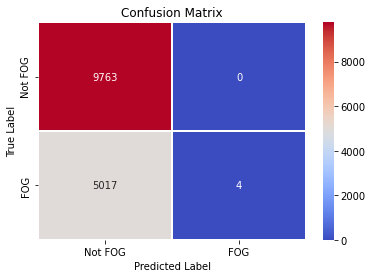

>#1: 66.065
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_1 (Conv1D)            (None, 3, 64)             512       
                                                                 
 dropout_6 (Dropout)         (None, 3, 64)             0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 100)               6500      
                                                                 
 dense_13 (Dense)            (None, 2)                 202       
                                         

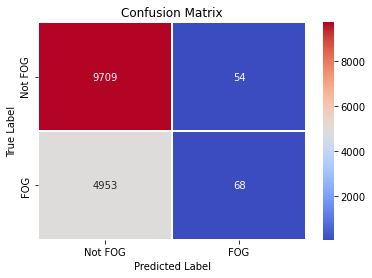

>#2: 66.132
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_1 (Conv1D)            (None, 3, 64)             512       
                                                                 
 dropout_7 (Dropout)         (None, 3, 64)             0         
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 100)               6500      
                                                                 
 dense_15 (Dense)            (None, 2)                 202       
                                         

KeyboardInterrupt: ignored

In [22]:
# run the experiment
run_experiment()